![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
import warnings
warnings.filterwarnings('ignore')

### Importar paquetes

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math 
from sklearn import datasets

from sklearn import metrics
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
# Importación de librerías
%matplotlib inline
import pandas as pd

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,0,0,0,1,0,0,0
11,13995,2014,39972,0,0,0,0,1,0,0
167,17941,2016,18989,0,0,0,0,0,1,0
225,12493,2014,51330,0,0,0,1,0,0,0
270,7994,2007,116065,0,1,0,0,0,0,0


In [4]:
data.shape

(10495, 10)

In [5]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [6]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [7]:
X_train

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
318288,2014,39988,0,0,0,0,0,1,0
333638,2007,38904,0,0,0,0,1,0,0
234716,2016,29607,0,0,0,0,0,1,0
208752,2014,50756,0,0,0,0,0,1,0
348892,2017,10506,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...
218085,2010,84057,0,0,0,0,1,0,0
198455,2012,93770,0,1,0,0,0,0,0
205572,2010,88644,0,0,1,0,0,0,0
33541,2015,26180,0,0,0,0,0,1,0


In [8]:
#Usaremos describe para hacer un benchmark de los datos
data.describe()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
count,10495.000000,10495.000000,10495.000000,10495.000000,10495.000000,10495.000000,10495.000000,10495.000000,10495.000000,10495.000000
mean,14538.403716,2013.553883,52509.430395,0.056313,0.158456,0.012292,0.048213,0.236494,0.376370,0.111863
std,3922.420961,3.116585,36791.736601,0.230535,0.365186,0.110189,0.214227,0.424949,0.484498,0.315213
min,5002.000000,1998.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11999.000000,2012.000000,26461.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,15000.000000,2014.000000,41680.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,16999.000000,2016.000000,71355.500000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,32444.000000,2018.000000,232658.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
iqr = data['Price'].quantile(0.75) - data['Price'].quantile(0.25)
print("IQR del precio:", iqr)

IQR del precio: 5000.0


### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [10]:
# Celda 1
###################################### PARAMETROS ######################################################
# Parametros y criterios de parada
max_depth = 3
num_pct = 10
min_gain=0.001


###################################### FUNCIONES ######################################################
# Funcion gini index
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)
# funcion impureza gini
def gini_impurity(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)    
    return gini_impurity_

#función mejor split para calcular la mejor variable y el punto de corte para hacer la bifurcación
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])    
    best_split = [0, 0, 0]  # j, split, gain    
    # Para todas las varibles 
    for j in features:        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)                        
            if gain > best_split[2]:
                best_split = [j, split, gain]    
    return best_split

#función para hacer el crecimiento recursivo del arbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    #validación condición 1 observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)    
    
    # Guardar el árbol y estimar la predicción
    y_pred = y.mean()  
    y_prob = y.mean()     
    tree = dict(y_pred=y_pred,  level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree       
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]
    # Siguiente iteración para cada partición    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)    
    return tree


# Función para predicciones según las variables 'X' y el árbol 'tree'

def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']            
    else:        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

###################################### EJECUCIÓN ######################################################

print('Creando árbol con hiperparámetros fijos')
tree_grow(X_train,y_train, level=0, min_gain=0.001, max_depth=3, num_pct=10)
tree = tree_grow(X_train,y_train, level=0, min_gain=0.001, max_depth=3, num_pct=10)

print(f'\n\nGenerando predicción')
y_pred_Tree= tree_predict(X_test,tree)

mae_Tree = mean_absolute_error(y_test, y_pred_Tree)
rmse_Tree = mean_squared_error(y_test, y_pred_Tree, squared=False)
mse_Tree = mean_squared_error(y_test, y_pred_Tree)

print(f'El MAE es {mae_Tree} ')
print(f'El RMSE es {rmse_Tree} ')
print(f'El MSE es {mse_Tree} ')

Creando árbol con hiperparámetros fijos


{'y_pred': 14508.073389276064,
 'level': 0,
 'split': [0, 2014.0],
 'n_samples': 7031,
 'gain': 17412158.538160443,
 'sl': {'y_pred': 10234.929955947136,
  'level': 1,
  'split': [0, 2012.0],
  'n_samples': 2270,
  'gain': 8039318.299921066,
  'sl': {'y_pred': 8737.28071379547,
   'level': 2,
   'split': [1, 97798.72727272728],
   'n_samples': 1457,
   'gain': 2218560.9485784173,
   'sl': {'y_pred': 9891.465256797583,
    'level': 3,
    'split': -1,
    'n_samples': 662,
    'gain': 1805269.9185358882},
   'sr': {'y_pred': 7776.186163522013,
    'level': 3,
    'split': -1,
    'n_samples': 795,
    'gain': 1238287.4041553736}},
  'sr': {'y_pred': 12918.90897908979,
   'level': 2,
   'split': [1, 73300.81818181818],
   'n_samples': 813,
   'gain': 2615740.375015855,
   'sl': {'y_pred': 13964.06546275395,
    'level': 3,
    'split': -1,
    'n_samples': 443,
    'gain': 942735.5531387925},
   'sr': {'y_pred': 11667.545945945945,
    'level': 3,
    'split': -1,
    'n_samples': 370,
 



Generando predicción
El MAE es 1445.8091325887447 
El RMSE es 1921.0003286740268 
El MSE es 3690242.262765719 


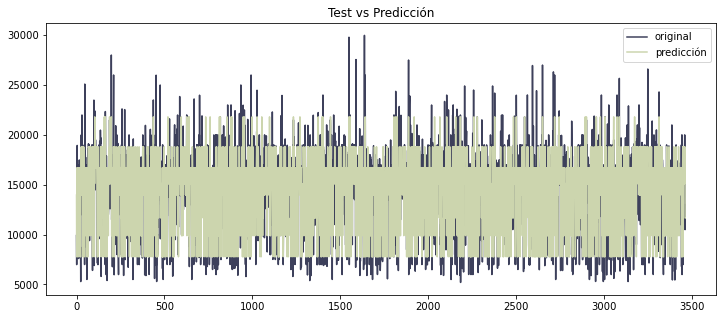

In [11]:
x_ax = range(len(y_test))
plt.figure(figsize=(12,5))
plt.plot(x_ax, y_test, label="original", color='#3d405b')
plt.plot(x_ax, y_pred_Tree, label="predicción", color='#ccd5ae')
plt.title("Test vs Predicción")
plt.legend()
plt.show();

#### Análisis

Se generó un árbol de decisión manualmente, calibrando algunos parámetros. Se obtuvieron los siguientes resultados:
    
* El MAE es 1445.8 
* El RMSE es 1921.0
* El MSE es 3690242.3

Es decir, el precio real versus la predicción, en promedio, tienen un error de USD 1445.8. En lo que respecta a los resultado de RMSE, estos nos indican que nuestras predicciones, en promedio, tienen un error de USD 1921.0. Estos son los datos iniciales, que usaremos también para comparar con los modelos siguientes.

Adicionalmente, a nivel gráfico se puede observar una especie de límites en las predicciones realizadas por el árbol manual, que impiden predecir los valores un poco más extremos. Esto se debe corresponder con cada una de las particiones realizadas por el árbol.     
    

### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [12]:
# Celda 2
#Se convierten X_train y y_train a arrays

X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

def bagging_manual(XTrain,yTrain,XTest,yTest,numArboles):
    
    arbol_pred = [] #espacio para guardar los predictores de cada árbol generado según numArboles
        
# muestreo con reemplazo de 1 a n - se realizará con el 80% de datos. En Y train se seleccionan las mismas filas
#este resmuestreo de filas es el bootstrap

    for i in range(numArboles): #se itera sobre cada árbol                       
            
        #remuestreo de las filas dentro del conjunto de datos, con reemplazo
        num_filas = int(len(XTrain)*0.8) #cálculo del 80% de las filas de XTrain
        filas_azar = np.random.choice(XTrain.shape[0],size=num_filas,replace=True) #array con los índices de filas aleatorios
         
        #selección del set de datos para cada árbol, con el 80% de filas aleatorias con reemplazo
        predictor = XTrain[filas_azar,:]
                   
        #Árbol de regresión     
        
        arbol = DecisionTreeRegressor()
        #se entrena con el XTrain con filas aleatorias y con yTrain usando las mismas filas aleatorias de XTrain
        arbol  = arbol.fit(predictor, yTrain[filas_azar])
        #se predicen los valores con el set de test y se guarda el resultado de este árbol
        arbol_pred.append(arbol.predict(XTest))     
     
    #Se calcula el Y predicho empleando el promedio de las predicciones de cada árbol generado
    y_pred = np.mean(arbol_pred, axis=0)
    
    #Se calcula el MSE final con el Y predicho
    MSE_final = mean_squared_error(yTest, y_pred, squared = True)
    MAE_final = mean_absolute_error(yTest, y_pred)
    RMSE_final = mean_squared_error(yTest, y_pred, squared=False)
    
        
    return   print(f"MAE: {MAE_final}\nRMSE: {RMSE_final}\nMSE: {MSE_final}"), y_pred, MSE_final, MAE_final,RMSE_final

In [13]:
modelo, predicciones_bag, MSE_final, MAE_final,RMSE_final   = bagging_manual(X_train,y_train,X_test,y_test,10)

MAE: 1323.3253255938637
RMSE: 1777.642417937001
MSE: 3160012.5660489076


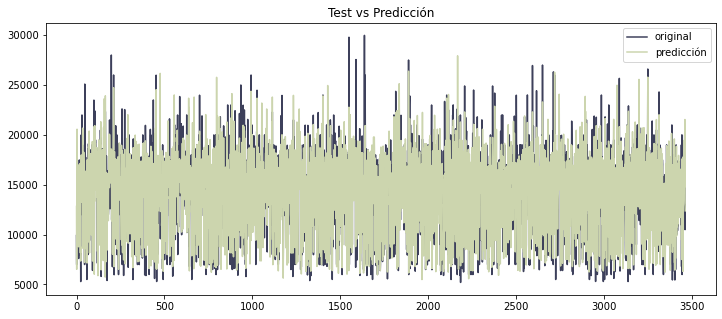

In [14]:
x_ax = range(len(y_test))
plt.figure(figsize=(12,5))
plt.plot(x_ax, y_test, label="original", color='#3d405b')
plt.plot(x_ax, predicciones_bag, label="predicción", color='#ccd5ae')
plt.title("Test vs Predicción")
plt.legend()
plt.show();

#### Análisis

Se generó un modelo de bagging manualmente, con 10 árboles de decisión, empleando remuestreo aleatorio de las filas con reemplazo. Se usaron en cada caso solo el 80% de los datos. Se obtuvieron los siguientes resultados:
    
* MAE: 1323.3
* RMSE: 1777.6
* MSE: 3160012.6

Es decir, el precio real versus la predicción, en promedio, tienen un error de USD 1323.3. En lo que respecta a los resultado de RMSE, estos nos indican que nuestras predicciones, en promedio, tienen un error de USD 1777.6. Estos valores son un poco inferiores a los obtenidos con el árbol de decisión manual del punto 1, mostrando la ventaja del remuestreo y el ensamble. 

Adicionalmente, a nivel gráfico se puede observar que el modelo ya presenta mayor flexibilidad, con un mejor ajuste de las predicciones a los valores reales.
    

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [15]:
# Calculo de log(n_features)
n_features = X.columns
n_features

M_features = np.log(len(n_features))

M_features = round(M_features / len(n_features),3) #calculamos la proporción de variables predictoras a usar
M_features

Index(['Year', 'Mileage', 'M_Camry', 'M_Camry4dr', 'M_CamryBase', 'M_CamryL',
       'M_CamryLE', 'M_CamrySE', 'M_CamryXLE'],
      dtype='object')

0.244

In [16]:
# Celda 3
# Estimación del Modelo y Entrenamiento del modelo
ModelBagR = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=10, max_features=M_features, n_jobs=-1, 
                            random_state=0)
ModelBagR.fit(X_train, y_train)

BaggingRegressor(base_estimator=DecisionTreeRegressor(), max_features=0.244,
                 n_jobs=-1, random_state=0)

In [17]:
# Cálculo de las predicciones en la muestra de evaluación
P_MBagR = ModelBagR.predict(X_test)

In [18]:
# Calculo de métricas
maeBagR = mean_absolute_error(y_test, P_MBagR)
rmseBagR = mean_squared_error(y_test, P_MBagR, squared=False)
mseBagR = mean_squared_error(y_test, P_MBagR)
print("Mean Absolute Error:", maeBagR)
print("Root Mean Squared Error:", rmseBagR)
print("Mean Squared Error:", mseBagR)

Mean Absolute Error: 1827.342848084451
Root Mean Squared Error: 2354.448602808742
Mean Squared Error: 5543428.223268038


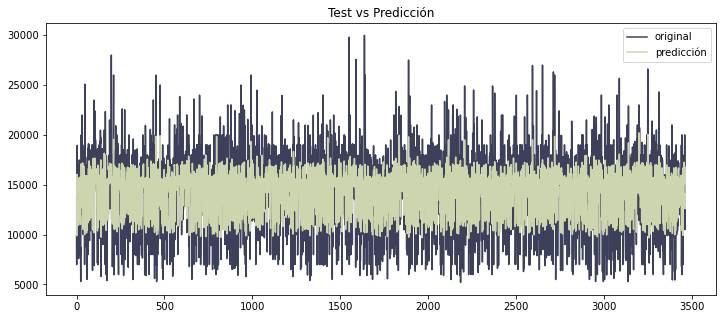

In [19]:
x_ax = range(len(y_test))
plt.figure(figsize=(12,5))
plt.plot(x_ax, y_test, label="original", color='#3d405b')
plt.plot(x_ax, P_MBagR, label="predicción", color='#ccd5ae')
plt.title("Test vs Predicción")
plt.legend()
plt.show();

#### Análisis

Se generó un modelo de bagging con la librería, con 10 árboles de decisión, ajustando el parámetro `max_features` igual a `log(n_features)`. Se obtuvieron los siguientes resultados:
    
* MAE: 1827.3
* RMSE: 2354.4
* MSE: 5543428.2

Al usar la Métrica MSE para evaluar el desempeño del modelo bagging para regresión, podemos concluir que el modelo tiene un muy bajo desempeño, al ser el valor del MSE un valor demasiado alto.

El precio real versus la predicción, en promedio, tienen un error de USD 1827.3. En lo que respecta a los resultado de RMSE, estos nos indican que nuestras predicciones, en promedio, tienen un error de USD 2354.4. Estos valores son superiores a los obtenidos en los dos puntos anteriores. Esto se podría explicar por la restricción en el parámetro de `max_features`, donde fundamentalmente el modelo solo empleaba dos variables en cada árbol de decisión.  

Adicionalmente, a nivel gráfico se puede observar que el modelo ya presenta poca flexibilidad y se limitan sus predicciones solo a un rango de valores.

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [20]:
# Celda 4
# Estimación del Modelo y Entrenamiento del modelo
ModelRFR_A = RandomForestRegressor()
ModelRFR_A.fit(X_train, y_train)

RandomForestRegressor()

In [21]:
# Cálculo de las predicciones en la muestra de evaluación
P_MRFR_A = ModelRFR_A.predict(X_test)

In [22]:
# Calculo de métricas
maeRFR_A = mean_absolute_error(y_test, P_MRFR_A)
rmseRFR_A = mean_squared_error(y_test, P_MRFR_A, squared=False)
mseRFR_A = mean_squared_error(y_test, P_MRFR_A)
print("Mean Absolute Error:", maeRFR_A)
print("Root Mean Squared Error:", rmseRFR_A)
print("Mean Squared Error:", mseRFR_A)

Mean Absolute Error: 1310.9441066302904
Root Mean Squared Error: 1762.6636666314982
Mean Squared Error: 3106983.201662798


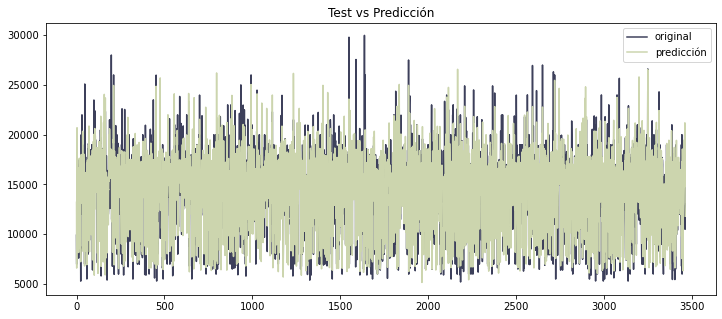

In [23]:
x_ax = range(len(y_test))
plt.figure(figsize=(12,5))
plt.plot(x_ax, y_test, label="original", color='#3d405b')
plt.plot(x_ax, P_MRFR_A, label="predicción", color='#ccd5ae')
plt.title("Test vs Predicción")
plt.legend()
plt.show();

#### Análisis

Se generó un modelo de random forest con la librería, sin ajustes de parámetros. Se obtuvieron los siguientes resultados:
    
* MAE: 1310.9
* RMSE: 1762.6
* MSE: 3106983.2

El precio real versus la predicción, en promedio, tienen un error de USD 1310.9 En lo que respecta a los resultado de RMSE, estos nos indican que nuestras predicciones, en promedio, tienen un error de USD 1762.6. Estos valores son inferiores a los calculados en todos los modelos anteriores, demostrando las bondades de este tipo de modelos, a pesar de no tener ajustes en los parámetros. 

Adicionalmente, a nivel gráfico este modelo genera predicciones que se ajustan bien a los datos reales.

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [24]:
# Celda 5
# Estimación del Modelo y Entrenamiento del modelo
#haremos paso a paso la calibración de los parámetros, empleando el MSE como métrica:

In [25]:
# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
estimator_range = range(10, 310, 10) #desde 10 hasta 300

# Definición de lista para almacenar el MSE promedio para cada valor de n_estimators
MSE = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
    clf = RandomForestRegressor(n_estimators=estimator, random_state=1, n_jobs=-1)
    MSE.append((cross_val_score(clf, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean())*-1)
    #multiplicamos por -1 para que el valor de MSE sea positivo. Buscamos el menor valor

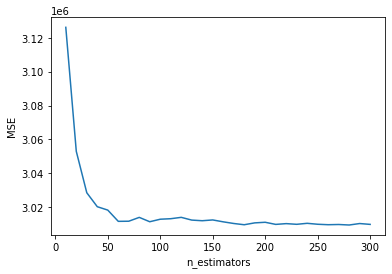

In [26]:
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(estimator_range, MSE)
plt.xlabel('n_estimators')
plt.ylabel('MSE')
plt.show();

Encontramos que aproximadamente en 180 estimadores se consigue el menor valor del MSE.

In [27]:
# Creación de lista de valores para iterar sobre diferentes valores max_depth
deep_range = range(1, 11, 1) #desde 1 hasta 10

# Definición de lista para almacenar el MSE promedio para cada valor de profundidad
MSE_deep = []

# Uso de un 5-fold cross-validation para cada valor de profundidad (empleando 180 estimadores según análisis anterior)
for depth in deep_range:
    clf = RandomForestRegressor(n_estimators=180, max_depth=depth, random_state=1, n_jobs=-1)
    MSE_deep.append((cross_val_score(clf, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean())*-1)

Text(0.5, 0, 'max_depth')

Text(0, 0.5, 'MSE')

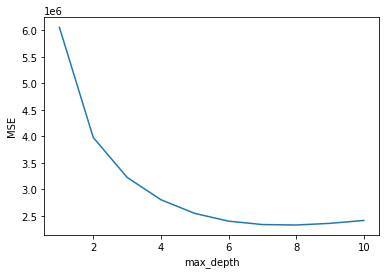

In [28]:
# Gráfica del desempeño del modelo vs max_depth
plt.plot(deep_range, MSE_deep)
plt.xlabel('max_depth')
plt.ylabel('MSE')

Se encontró que 8 es el valor que brinda el menor MSE respecto al parámetro de max_depth

In [29]:
# Creación de lista de valores para iterar sobre diferentes valores de max_features
feature_range = range(1, len(n_features)+1)

# Definición de lista para almacenar el MSE promedio para cada valor de max_features
MSE_feature = []

# Uso de un 10-fold cross-validation para cada valor de max_features
for feature in feature_range:
    clf = RandomForestRegressor(n_estimators=180, max_depth=8, max_features=feature, random_state=1, n_jobs=-1)
    MSE_feature.append((cross_val_score(clf, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean())*-1)

Text(0.5, 0, 'max_features')

Text(0, 0.5, 'MSE')

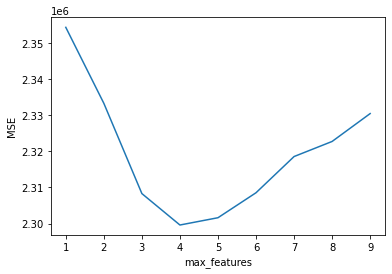

In [30]:
# Gráfica del desempeño del modelo vs la cantidad de max_features
plt.plot(feature_range, MSE_feature)
plt.xlabel('max_features')
plt.ylabel('MSE')

En este caso, el max_feature que brinda un menor MSE es igual a 4

In [31]:
# Establecemos los parámetros a calibrar, usando los mejores parámetros vistos en los puntos anteriores
param_grid = {
    'n_estimators': [50, 80, 150, 180, 200],
    'max_depth': [7, 8, 9],
    'max_features': [3, 4, 5]
}

#finalmente corremos un modelo con los parámetros a ajustar
ModelRFR_B = RandomForestRegressor()

grid_search_RF = GridSearchCV(
    ModelRFR_B, param_grid, scoring='neg_mean_squared_error',
    cv=10)

In [32]:
# Formulación de modelo 
grid_search_RF.fit(X_train, y_train)
# Formulando los parámetros con mejor desempeño
best_model_RF = grid_search_RF.best_estimator_
best_hyperparams_RF = grid_search_RF.best_params_

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [7, 8, 9], 'max_features': [3, 4, 5],
                         'n_estimators': [50, 80, 150, 180, 200]},
             scoring='neg_mean_squared_error')

In [33]:
#Formulando predicciones
y_pred_RF = best_model_RF.predict(X_test)

# Evaluando desempeño
mae_RF = mean_absolute_error(y_test, y_pred_RF)
rmse_RF = mean_squared_error(y_test, y_pred_RF, squared=False)
mse_RF = mean_squared_error(y_test, y_pred_RF)

print("Parámetros calibrados:", best_hyperparams_RF)
print("MAE de modelo calibrado:", mae_RF)
print("RMSE de modelo calibrado:", rmse_RF)
print("MSE de modelo calibrado:", mse_RF)

Parámetros calibrados: {'max_depth': 8, 'max_features': 4, 'n_estimators': 150}
MAE de modelo calibrado: 1139.4919375783152
RMSE de modelo calibrado: 1553.4393076710078
MSE de modelo calibrado: 2413173.68261738


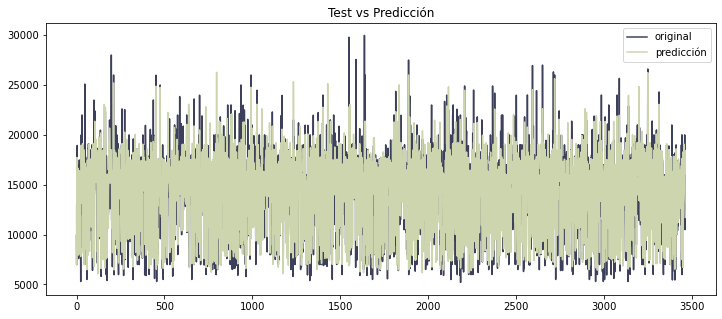

In [34]:
x_ax = range(len(y_test))
plt.figure(figsize=(12,5))
plt.plot(x_ax, y_test, label="original", color='#3d405b')
plt.plot(x_ax, y_pred_RF, label="predicción", color='#ccd5ae')
plt.title("Test vs Predicción")
plt.legend()
plt.show();

#### Análisis

Se generó un modelo de random forest con la librería, ajustando los parámetros de n_estimators, max_depth y max_features.
Inicialmente se realizó una exploración gráfica para el ajuste de cada parámetro. Finalmente, se empleó gridsearch con los mejores prospectos para obtener el modelo con la mejor combinación de los parámetros.

Los parámetros seleccionados fueron: 'max_depth': 8, 'max_features': 4, 'n_estimators': 150

Teniendo en cuenta los gráficos y el material de estudio, evidenciamos que el ajuste de los parámetros condiciona de manera determiante los resultados del random forest: 

* El parámetro n_estimators, indica la cantidad de árboles a construir por el modelo en el bosque. A mayor número de árboles se puede obtener un mejor resultado en las predicciones dado que hay más datos con los cuales hacer el promedio. Sin embargo, a partir de cierto número de árboles, la mejora ya no resulta significativa. Por ejemplo, en nuestro modelo, aproximadamente desde 50 árboles la mejora del MSE es muy poca. 
* El parámetro max_depth, indica la profundidad de cada arbol. Valores más altos mejoran el desempeño del modelo ayudando a bajar el sesgo y mejorar la varianza. Sin embargo, también hay un momento en el que una profundidad muy alta comienza a afectar su desempeño. Esto también lo podemos ver en la gráfica, donde después del valor 8 comienza a aumentar de nuevo el MSE.  
* El parámetro max_features, indica la cantidad de variables a usar para cada partición. Este debe ser cuidadosamente ajustado, dado que valores muy pequeños o muy grandes iniciden de forma importante en el desempeño del modelo. En nuestro caso esto se refleja muy bien en el gráfico y se pudo seleccionar una cantidad adecuada de features de 4 (en este caso equivalen aproximadamente al 44% de las variables disponibles). 

Se obtuvieron los siguientes resultados:

* MAE: 1139.5
* RMSE: 1553.4
* MSE: 2413173.7

El precio real versus la predicción, en promedio, tienen un error de USD 1139.5. En lo que respecta a los resultados de RMSE, estos nos indican que nuestras predicciones, en promedio, tienen un error de USD 1553.4. Estos valores son incluso mejores a los del randomforest sin calibrar, demostrando que este ajuste de los parámetros pueden mejorar las predicciones. 

Adicionalmente, a nivel gráfico este modelo genera predicciones que se ajustan bien a los datos reales.

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [35]:
# Celda 6

#Importamos libreria 
from xgboost import XGBRegressor

#Formulamos el modelo y lo entrenamos
modelo = XGBRegressor()
modelo.fit(X_train, y_train)
y_pred_xg1 = modelo.predict(X_test)

#Verificamos el desempeño del modelo

mae_xg1 = mean_absolute_error(y_test, y_pred_xg1)
rmse_xg1 = mean_squared_error(y_test, y_pred_xg1, squared=False)
mse_xg1 = mean_squared_error(y_test, y_pred_xg1)
print("Mean Absolute Error:", mae_xg1)
print("Root Mean Squared Error:", rmse_xg1)
print("Mean Squared Error:", mse_xg1)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

Mean Absolute Error: 1186.634392366123
Root Mean Squared Error: 1621.4197004256812
Mean Squared Error: 2629001.844928506


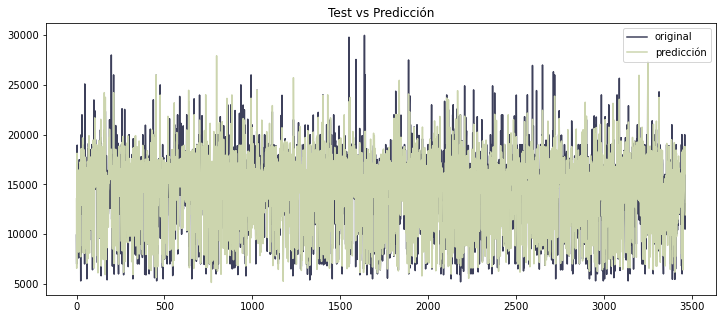

In [36]:
x_ax = range(len(y_test))
plt.figure(figsize=(12,5))
plt.plot(x_ax, y_test, label="original", color='#3d405b')
plt.plot(x_ax, y_pred_xg1, label="predicción", color='#ccd5ae')
plt.title("Test vs Predicción")
plt.legend()
plt.show();

#### Análisis

Se generó un modelo de xgboost con la librería, sin ajustes de parámetros. Se obtuvieron los siguientes resultados:

* MAE: 1186.6
* RMSE: 1621.4
* MSE: 2629001.8

Los resultados obtenidos anteriormente nos indican que nuestro modelo predice los precios de Camrys de segunda mano con un MAE de 1186.6 . Es decir, el precio real versus nuestra predicción, en promedio, tienen un error de USD 1186.6. En lo que respecta a los resultado de RMSE, estos nos indican que nuestras predicciones, en promedio, tienen un error de USD 1621.4.

En este momento, es importante mencionar entonces que, a pesar que nuestras predicciones no son 100% precisas, podemos concluir que el modelo no tienen un tan mal desempeño al comparar nuestros resultados de MAE y RMSE (USD 1186.6 y USD 1621.4, respectivamente) con la desviación estandar del precio de todos los registros (USD 3922.4). Nuestras predicciones, en promedio, dan un resultado menor que la desviación estandar. Adicionalmente, al observar los cuartiles de Price, podemos comprobar que nuestras predicciones son menores que el IQR de Price el cual es USD 5000.

Adicionalmente, a nivel gráfico este modelo genera predicciones que se ajustan bien a los datos reales.

Procederemos a calibrar el modelo y buscar mejoras.

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [37]:
# Celda 7

#Importamos GridSearch
from sklearn.model_selection import GridSearchCV
# Establecemos los parámetros a calibrar 
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'gamma': [0.1, 0.5, 1],
    'colsample_bytree': [0.5,0.6,0.7]
}

# La grilla de búsqueda emplea cross validation de 10, y nuestros hiperparámetros serán evaluados en base a dos métricas
grid_search = GridSearchCV(
    modelo, param_grid, scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'],
    cv=10, refit='neg_mean_absolute_error')

In [38]:
# Formulacion de modelo 
grid_search.fit(X_train, y_train)
# Formulando los parámetros con mejor desempeño
best_model = grid_search.best_estimator_
best_hyperparams = grid_search.best_params_

GridSearchCV(cv=10,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None,...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None

In [39]:
#Formulando predicciones
y_pred_xg_cal = best_model.predict(X_test)
# Evaluando desempeño
rmse_xg_cal = mean_squared_error(y_test, y_pred_xg_cal, squared=False)
mae_xg_cal = mean_absolute_error(y_test, y_pred_xg_cal)
mse_xg_cal = mean_squared_error(y_test, y_pred_xg_cal)
print("Parámetros calibrados:", best_hyperparams)
print("MAE de modelo calibrado:", mae_xg_cal)
print("RMSE de modelo calibrado:", rmse_xg_cal)
print("MSE de modelo calibrado:", mse_xg_cal)

Parámetros calibrados: {'colsample_bytree': 0.7, 'gamma': 0.1, 'learning_rate': 0.05}
MAE de modelo calibrado: 1130.2710151231868
RMSE de modelo calibrado: 1545.4675185825547
MSE de modelo calibrado: 2388469.8509937194


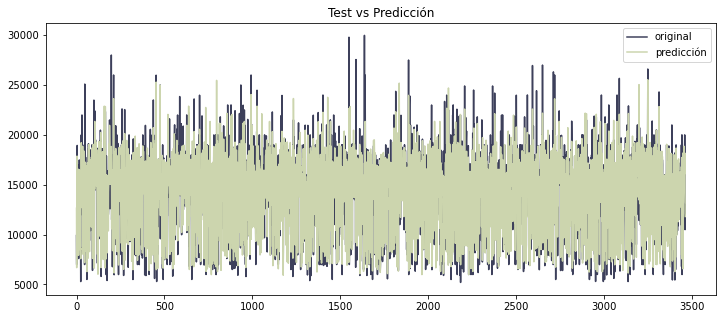

In [40]:
x_ax = range(len(y_test))
plt.figure(figsize=(12,5))
plt.plot(x_ax, y_test, label="original", color='#3d405b')
plt.plot(x_ax, y_pred_xg_cal, label="predicción", color='#ccd5ae')
plt.title("Test vs Predicción")
plt.legend()
plt.show();

#### Análisis

Se generó un modelo de xgboost con la librería, ajustando los parámetros. Se obtuvieron los siguientes resultados:

* MAE: 1130.3
* RMSE: 1545.5
* MSE: 2388469.9

Los resultados obtenidos anteriormente nos indican que nuestro modelo predice los precios de Camrys de segunda mano con un MAE de 1130.3 . Es decir, el precio real versus nuestra predicción, en promedio, tienen un error de USD 1130.3. En lo que respecta a los resultado de RMSE, estos nos indican que nuestras predicciones, en promedio, tienen un error de USD 1545.5. Esto representa una mejora en comparación a los resultado del Punto 6.

Para este ejercicio, empleamos el uso de gridsearch para calibrar los siguiente parámetros de XGBoost: learning_rate, gamma, colsample_bytree.

* 1.colsample_bytree:0.7
Significa que nuestro modelo calibrado solo usará un 70% de las variables predictoras. Esto contribuirá a reducir el overfitting en el modelo. Contamos con nueve variables predictoras, por lo que con este parámetro indicamos al modelo que solo use el 70% de estas variables, lo que significaría seis variables.

* 2.gamma: 0.1
Este parámetro nos permite determinar los criterios para que cada árbol haga un split en base a una reducción mínima en el RMSE o MAE. El valor 0.1 indica que nuestro modelo hará los splits si la reducción en RMSE o MAE es al menos 0.1, de no ser así el árbol no se bifurcará más.

* 3.learning_rate: 0.05
Este parámetro determina la tasa de aprendizaje del modelo durante la fase de training. El valor que se le asigna establece cómo se irán ajustando los parámetros en cada iteración. En nuestro caso, 0.05 es una tasa de aprendizaje lenta y conservadora con el objetivo de no forzar al algoritmo a desviarse hacia resultados no tan óptimos.

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

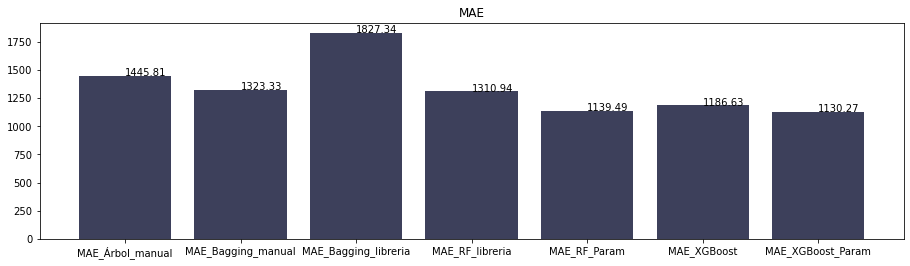

In [42]:
# Celda 8
# MAE
fig = plt.figure(figsize = (12,3))
ax = fig.add_axes([0,0,1,1])
ax.set_title("MAE")
ejeX = ['MAE_Árbol_manual', 'MAE_Bagging_manual', 'MAE_Bagging_libreria',
       "MAE_RF_libreria", "MAE_RF_Param", "MAE_XGBoost", "MAE_XGBoost_Param"]
ejeY = [round(mae_Tree, 2), round(MAE_final, 2), round(maeBagR, 2), round(maeRFR_A, 2), round(mae_RF, 2), round(mae_xg1, 2),
       round(mae_xg_cal, 2)]
ax.bar(ejeX, ejeY, color = '#3d405b')
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY,plt)
plt.show();

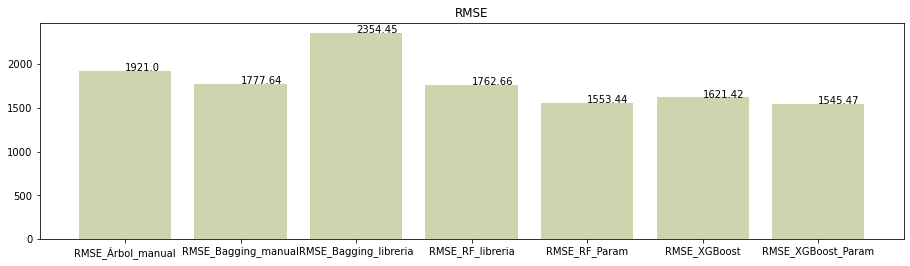

In [43]:
# RMSE
fig = plt.figure(figsize = (12,3))
ax = fig.add_axes([0,0,1,1])
ax.set_title("RMSE")
ejeX = ['RMSE_Árbol_manual', 'RMSE_Bagging_manual', 'RMSE_Bagging_libreria',
       "RMSE_RF_libreria", "RMSE_RF_Param", "RMSE_XGBoost", "RMSE_XGBoost_Param"]
ejeY = [round(rmse_Tree, 2), round(RMSE_final, 2), round(rmseBagR, 2), round(rmseRFR_A, 2), round(rmse_RF, 2), round(rmse_xg1, 2),
       round(rmse_xg_cal, 2)]
ax.bar(ejeX, ejeY, color = '#ccd5ae')
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY,plt)
plt.show();

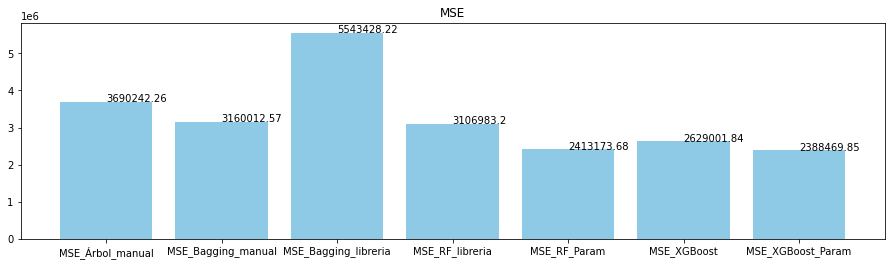

In [44]:
# MSE
fig = plt.figure(figsize = (12,3))
ax = fig.add_axes([0,0,1,1])
ax.set_title("MSE")
ejeX = ['MSE_Árbol_manual', 'MSE_Bagging_manual', 'MSE_Bagging_libreria',
       "MSE_RF_libreria", "MSE_RF_Param", "MSE_XGBoost", "MSE_XGBoost_Param"]
ejeY = [round(mse_Tree, 2), round(MSE_final, 2), round(mseBagR, 2), round(mseRFR_A, 2), round(mse_RF, 2), round(mse_xg1, 2),
       round(mse_xg_cal, 2)]
ax.bar(ejeX, ejeY, color = '#8ecae6')
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY,plt)
plt.show();

#### Análisis

Se realizaron los gráficos comparativos con todos los modelos entrenados. Para ellos usamos las métricas de MAE, RMSE y MSE. Podemos identificar que el modelo con mejor desempeño fue el xgboost con ajuste de parámetros (XGBoost_Param), mienstras que el modelo con peores resultados fue el bagging con la librería (donde el parámetro `max_features` fue igual a `log(n_features)`). 

El mejor modelo fue XGBoost. Esto coincide con lo esperado según lo revisado en clase, dado que este tipo de modelos usan algoritmos mejorados que incluyen tree pruning (poda de hojas que no contribuyen al modelo), incorporan regularización (penalizan modelos muy complejos) y realiza validación cruzada en cada iteración. Aunque en esta base no había datos faltantes, otra de las carácteristicas positivas del XGBoost es que maneja los valores perdidos de manera óptima (encuentra el mejor valor de imputación para minimizar la pérdida de entrenamiento). Adicionalmente está optimizado para funcionar con paralelización y su uso del caché. 

Por otro lado, el modelo con el peor desempeño fue el bagging con librería. Inicialmente esto no era esperado, dado que en teoría debería ser mejor que el árbol de decisión único realizado manualmente (punto 1), mientras que este ensamble usaba 10 árboles. Esto se puede explicar por la restricción en el parámetro `max_features`, el cual fue igual a `log(n_features)`, limitando el uso de solo dos variables dentro del modelo. Podemos evidenciar un alto sesgo al revisar el gráfico de este modelo. Para mejorar este aspecto podríamos realizar un ajuste más completo de los parámetros, especialmente max_features. 

Finalmente, mencionar que ninguno de los modelos logró predecir adecuadamente los valores extremos o atípicos (outliers). 